# Importing libraries

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from IPython.display import clear_output

In [5]:
env = gym.make('CartPole-v0')
env.reset()
for i in range(10):
    env.step(0)
    env.render()

C:\Users\tpath\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Creating linear layer network for Function approximation

In [2]:
class DQN(nn.Module):
    def __init__(self, input_dims, lr):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dims, out_features=32)  #
        self.fc2 = nn.Linear(in_features=32, out_features=2)
        #self.fc3 = nn.Linear(in_features=128, out_features=2)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        
    def forward(self, t):
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        #t = F.relu(t)
        #t = self.fc3(t)
        return t

In [3]:
class Agent():
    def __init__(self, gamma, eps, eps_min, eps_decay, num_actions, device):
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, rate, state, policy_net):
        if random.random() > rate:
            obs = torch.tensor([state], dtype=torch.float32).to(self.device)
            return policy_net(obs).argmax(dim=1).item()
        else:
            return np.random.choice(self.num_actions)

In [4]:
random.random()

0.18678464459988064

In [5]:
class ReplayMemory():
    def __init__(self, capacity, batch_size, input_dims, eps, eps_min, eps_decay):
        self.capacity = capacity
        self.batch_size = batch_size
        self.state_memory  = np.zeros((capacity, input_dims), dtype=np.float32)
        self.action_memory = np.zeros(capacity, dtype=np.int32)
        self.reward_memory = np.zeros(capacity, dtype=np.float32)
        self.next_state_memory = np.zeros((capacity, input_dims), dtype=np.float32)
        self.terminal_memory = np.zeros(capacity, dtype=np.bool)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.experience_ctr = 0
        
    def store(self, state, action, reward, next_state, terminal):
        index = self.experience_ctr % self.capacity
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = terminal
        self.experience_ctr += 1
        
    def can_provide_batch(self):
        return self.experience_ctr >= batch_size
    
    def give_batch(self):
        length = min(self.experience_ctr, self.capacity)
        batch = np.random.choice(length, self.batch_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]
        return (states, actions, rewards, next_states, terminals)
    
    def get_epsilon(self):
        #print(self.experience_ctr)
        rate = self.eps_min + (self.eps - self.eps_min) * math.exp(-1. * self.experience_ctr / self.eps_decay)
        return rate

In [6]:
batch_size = 128
gamma = 0.999
eps = 0.9
eps_min = 0.05
eps_decay = 500
update_rate = 10
capacity = 100000
lr = 0.001
input_dims = 4
num_episodes = 150

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
policy_net = DQN(input_dims, lr).to(device)
target_net = DQN(input_dims, lr).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
  (loss): MSELoss()
)

In [9]:
pytorch_total_params = sum(p.numel() for p in policy_net.parameters())
print(f"total parameters = {pytorch_total_params}")

total parameters = 226


In [9]:
agent = Agent(gamma, eps, eps_min, eps_decay, 2, device)
memory = ReplayMemory(capacity, batch_size, 4, eps, eps_min, eps_decay)

In [10]:
env = gym.make('CartPole-v0')

In [11]:
def get_tensors(batch, device):
    states = torch.tensor(batch[0]).to(device)
    actions = batch[1]
    rewards = torch.tensor(batch[2]).to(device)
    next_states = torch.tensor(batch[3]).to(device)
    dones = torch.tensor(batch[4]).to(device)
    return states, actions, rewards, next_states, dones

In [12]:
score_track = []
eps_track = []
loss_track = []
batch_index = np.arange(batch_size, dtype = np.int32)
for episode in range(num_episodes):
    print(episode)
    score = 0
    terminal = False
    state = env.reset()
    while not terminal:
        rate = memory.get_epsilon()
        #print(rate)
        eps_track.append(rate)
        action = agent.select_action(rate, state, policy_net)
        next_state, reward, terminal, emp = env.step(action)
        memory.store(state, action, reward, next_state, terminal)
        state = next_state
        score += reward
        
        if memory.can_provide_batch():
            batch = memory.give_batch()
            states, actions, rewards, next_states, dones = get_tensors(batch, device)
            
            current_q_values = policy_net.forward(states)[batch_index, actions]
            current_q_values = current_q_values.reshape(-1,1)
            next_q_values = target_net.forward(next_states)
            next_q_values[dones] = 0.0
            next_q_values = torch.max(next_q_values, dim=1)[0].detach()
            
            target_q_values = (gamma * next_q_values) + rewards
            target_q_values = target_q_values.reshape(-1,1)
            #print(current_q_values.shape, next_q_values.shape, rewards.shape)
            policy_net.optimizer.zero_grad()
            loss = policy_net.loss(target_q_values, current_q_values)
            loss_track.append(loss.item())
            loss.backward()
            policy_net.optimizer.step()
            
    score_track.append(score)
    if episode%update_rate==0:
        target_net.load_state_dict(policy_net.state_dict())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


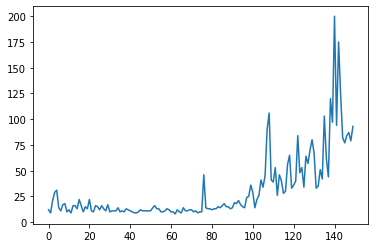

In [13]:
x = range(len(score_track))
plt.plot(x, score_track)

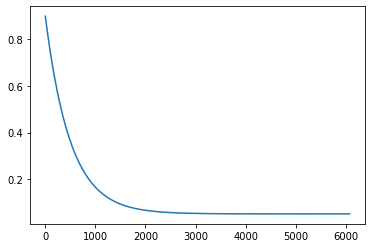

In [14]:
x = range(len(eps_track))
plt.plot(x, eps_track)

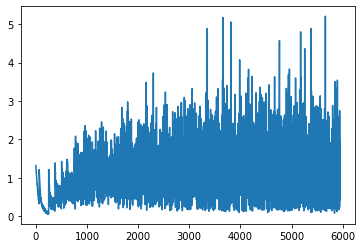

In [15]:
x = range(len(loss_track))
plt.plot(x, loss_track)

In [17]:
state = env.reset()
score = 0
done = False
avg_score = []
avg_score_track = []
for i in range(20):
    score = 0
    state = env.reset()
    done = False
    while not done:
        obs = torch.tensor(env.state, dtype=torch.float32).to(device)
        action = torch.argmax(policy_net(obs)).item()
        #action = agent.select_action(state, policy_net)
        next_state, reward, done, _ = env.step(action)
        score += reward
    
    avg_score.append(score)
print(np.mean(avg_score))    
#a = torch.tensor([[1,2,3,4], [1,1,1,1]], dtype=torch.float32).to(device)
#b = policy_net(a)
#print(b, b.shape)

123.2
